[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana10/2_entrenamiento_FINBERT.ipynb)

# Instalaciones

In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# FinBERT

En esta clase, mejoraremos lo hecho en la clase anterior (una regresión logística multiclase para clasificación de sentimiento)

Esto se hará utilizando un modelo BERT con ligeros cambios, ha sido entrenado refinadamente para tomar en cuenta términos financieros y posteriormente compararemos los resultados con la regresión.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [4]:
# Ver todos los módulos instalados y sus versiones
!pip list

Package                            Version
---------------------------------- ------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2025.1.6.0.33.42
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              24.3.0
audioread                          3.0.1
autograd             

In [5]:
# Info de un módulo en específico
!pip show pandas

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

In [7]:
import numpy as np
import pandas as pd
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
# tested in transformers==4.18.0, pytorch==1.7.1
import torch
import transformers
torch.__version__, transformers.__version__

('2.5.1+cu121', '4.47.1')

In [9]:
torch.cuda.is_available()

True

# Predicción con finBERT precargado

In [10]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [11]:
# Tareas a ejecutar
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

Device set to use cuda:0


Primer predicción:

In [12]:
results = nlp('Growth is not strong and we do not have liquidity.')  # 'Growth is strong and we have plenty of liquidity.' # aqui si tiene peso el orden de las palabras
print(results)

[{'label': 'Negative', 'score': 0.9918853044509888}]


## ¿Qué significa Tokenizar?

In [13]:
tokenizer.tokenize('Growth is strong but we do not have liquidity.') # separo las palabras, y las puso en minuscula, considerando la puntuacion

['growth', 'is', 'strong', 'but', 'we', 'do', 'not', 'have', 'liquidity', '.']

## Para que sirven los Tokens?

In [14]:
tokenizer.convert_tokens_to_ids(['growth', 'is', 'strong', 'but', 'we', 'do', 'not', 'have', 'liquidity', '.']) # ids que haen referencia a cada palabra, si se repite palabra se repite id

[64, 17, 253, 71, 13, 123, 30, 29, 466, 48]

Primer paso al procesar los textos.

In [15]:
tokenizer('Growth is strong but we do not have liquidity.')['input_ids'] # ids que entraran al modelo
# se agrego al inicio al final porque BERT necesita entender inicio y fin

[3, 64, 17, 253, 71, 13, 123, 30, 29, 466, 48, 4]

# Carga de datos

In [16]:
data = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana10/data/sentiment_data/Sentences_50Agree.txt', sep='.@', names=['text','label'], encoding='latin1', engine='python')
data

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,Net sales of the Paper segment decreased to EU...,negative


In [17]:
data = data.dropna(subset=['text', 'label'])

In [18]:
data = data.replace(['negative','neutral','positive'],[0,1,2])

<ipython-input-18-f046d0127da5>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(['negative','neutral','positive'],[0,1,2])


In [19]:
data

,text,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


In [21]:
df_train, df_test, = train_test_split(data, stratify=data['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3924, 2) (485, 2) (437, 2)


df_train

In [22]:
df_train

,text,label
886,Stora Enso will record a capital gain of EUR 3...,1
3625,"In addition to Russia , we now seek additional...",2
1886,`` Subscribers can browse free numbers with th...,1
1164,"ALEXANDRIA , Va. , Aug. 27 -- Timo Vataja of T...",1
1662,"The total scope of the project is about 38,000...",1
...,...,...
2085,Commencing the construction works of Pearl Pla...,2
2760,"According to Heikkil+ï¿½ , more than just `` r...",1
4246,The company has a continuous need for alloys s...,1
1371,The deliveries started in April 2006 and will ...,1


In [23]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)
# sacar enunciados con cierto numero de espacios
dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)
# formato para touch
dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [24]:
dataset_train

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3924
})

In [25]:
type(dataset_train)

datasets.arrow_dataset.Dataset

## Ejercicio

¿Como se ven los datasets preparados?

Traten de inspeccionar los datos y ver como son

In [26]:
df_train

,text,label
886,Stora Enso will record a capital gain of EUR 3...,1
3625,"In addition to Russia , we now seek additional...",2
1886,`` Subscribers can browse free numbers with th...,1
1164,"ALEXANDRIA , Va. , Aug. 27 -- Timo Vataja of T...",1
1662,"The total scope of the project is about 38,000...",1
...,...,...
2085,Commencing the construction works of Pearl Pla...,2
2760,"According to Heikkil+ï¿½ , more than just `` r...",1
4246,The company has a continuous need for alloys s...,1
1371,The deliveries started in April 2006 and will ...,1


In [27]:
#@title Antes de preprocesar el objeto Dataset

Dataset.from_pandas(df_train)[0]

{'text': 'Stora Enso will record a capital gain of EUR 33 million as a non-recurring financial item in its fourth quarter 2006 results ',
 'label': 1,
 '__index_level_0__': 886}

In [29]:
#@title Procesado
dataset_train[0] # MATRIX DE MATRICES - TENSOR
# el padding es el llenado de espacios de acuerdo a la longitud que se propuso anteriormente

{'label': tensor(1),
 'input_ids': tensor([    3,  9220,  2404, 20966,   688,    36,   956,    11,    65,   608,
             7,  5114,  3060,    27,    18,    11,  3159,    85,  2269,    39,
           366,    10,    38,   326,    47,   612,    83,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

# Configuración para entrenamiento

In [30]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=finbert,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.446147,0.823799
2,No log,0.416858,0.842105
3,No log,0.455995,0.855835
4,No log,0.529864,0.864989
5,0.407800,0.557046,0.862700


TrainOutput(global_step=615, training_loss=0.33951590545778354, metrics={'train_runtime': 700.2531, 'train_samples_per_second': 28.018, 'train_steps_per_second': 0.878, 'total_flos': 1290571313955840.0, 'train_loss': 0.33951590545778354, 'epoch': 5.0})

Evaluación

In [32]:
finbert.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.6711089611053467,
 'test_accuracy': 0.843298969072165,
 'test_runtime': 3.4957,
 'test_samples_per_second': 138.742,
 'test_steps_per_second': 4.577}

In [34]:
trainer.predict(dataset_test) # no asigna probabilidades sino busco el numero mas grande para clasificar [0,1,2] en cada vectorsito

PredictionOutput(predictions=array([[-8.130996 ,  6.558004 ,  1.1178086],
       [ 5.3011394, -4.711953 , -4.560594 ],
       [-4.1009536, -2.896042 ,  6.7825174],
       ...,
       [ 2.5086765, -4.855854 , -1.787823 ],
       [-6.1071534,  7.251982 , -5.646848 ],
       [-2.37507  ,  2.3272984, -5.3345747]], dtype=float32), label_ids=array([1, 0, 1, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1,
       1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1,
     

In [35]:
y_pred = trainer.predict(dataset_test).predictions

In [36]:
y_pred

array([[-8.130996 ,  6.558004 ,  1.1178086],
       [ 5.3011394, -4.711953 , -4.560594 ],
       [-4.1009536, -2.896042 ,  6.7825174],
       ...,
       [ 2.5086765, -4.855854 , -1.787823 ],
       [-6.1071534,  7.251982 , -5.646848 ],
       [-2.37507  ,  2.3272984, -5.3345747]], dtype=float32)

In [37]:
y_pred.argmax(axis=1) # aagarrar el elemento maximo de cada vector anterior

array([1, 0, 2, 1, 2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1,
       0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1,
       1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0, 0, 2,
       1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [38]:
comparativo = df_test.copy()

In [39]:
comparativo['predicted'] = y_pred.argmax(axis=1)

In [40]:
comparativo

,text,label,predicted
3905,The solution will be installed in the USA to s...,1,1
2756,"Scanfil , a systems supplier and contract manu...",0,0
469,`` The sale of the oxygen measurement business...,1,2
3300,The number of magazine and newspaper readers r...,1,1
3024,Martela said plans to expand its recycled furn...,2,2
...,...,...,...
3445,Vacon recently announced plans to build its No...,1,1
1331,"Sanoma also has an Executive Committee , in ac...",1,1
4073,"The operating loss amounted to EUR 0.8 mn , co...",0,0
1394,"The Lemminkainen Group , headquartered in Hels...",1,1


In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, log_loss

In [42]:
print(classification_report(comparativo['label'], comparativo['predicted']))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80        61
           1       0.89      0.86      0.87       288
           2       0.80      0.80      0.80       136

    accuracy                           0.84       485
   macro avg       0.81      0.84      0.83       485
weighted avg       0.85      0.84      0.84       485



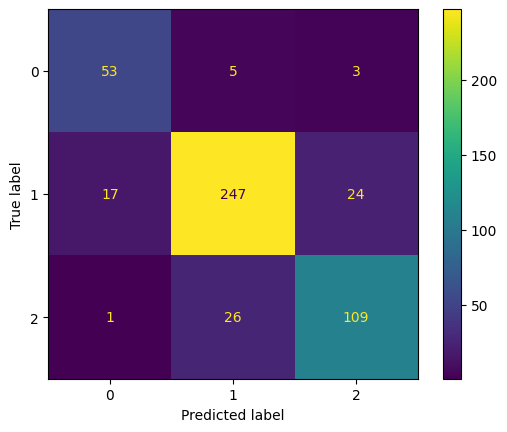

In [43]:
ConfusionMatrixDisplay.from_predictions(comparativo['label'], comparativo['predicted'])

In [44]:
comparativo['label'].value_counts()

,count
label,
1,288
2,136
0,61


In [45]:
comparativo['predicted'].value_counts()

,count
predicted,
1,278
2,136
0,71


Guardar el modelo refinado (fine tuned)

In [46]:
# Ojo, lo guardo en una carpeta que se borrará, es su decisión guardarlo en otro lado
trainer.save_model('finbert-sentiment/')

In [47]:
-np.log(1/3) # en tres clases esta es la peor perdida

1.0986122886681098

In [48]:
from scipy.special import softmax

In [50]:
np.set_printoptions(suppress=True)

In [51]:
y_pred

array([[-8.130996 ,  6.558004 ,  1.1178086],
       [ 5.3011394, -4.711953 , -4.560594 ],
       [-4.1009536, -2.896042 ,  6.7825174],
       ...,
       [ 2.5086765, -4.855854 , -1.787823 ],
       [-6.1071534,  7.251982 , -5.646848 ],
       [-2.37507  ,  2.3272984, -5.3345747]], dtype=float32)

In [52]:
np.asarray(softmax(y_pred, axis=1)) # convertir a probabilidades

array([[0.00000042, 0.9956797 , 0.00431989],
       [0.9999031 , 0.00004481, 0.00005213],
       [0.00001876, 0.00006261, 0.9999186 ],
       ...,
       [0.98595077, 0.00062442, 0.01342485],
       [0.00000158, 0.99999595, 0.0000025 ],
       [0.00898798, 0.9905461 , 0.00046598]], dtype=float32)

In [53]:
comparativo.label

,label
3905,1
2756,0
469,1
3300,1
3024,2
...,...
3445,1
1331,1
4073,0
1394,1


In [59]:
log_loss( np.asarray(comparativo.label), np.asarray( softmax(y_pred, axis=1) )   ) # softmax no es tan accurate al convertir a prob

0.671108969444388

# Método "antiguo": TextBlob

In [60]:
text = "Later that day Apple said it was revising down its earnings expectations in \
the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China. \
The news rapidly infected financial markets. Apple’s share price fell by around 7% in after-hours \
trading and the decline was extended to more than 10% when the market opened. The dollar fell \
by 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering \
some ground. Asian stockmarkets closed down on January 3rd and European ones opened lower. \
Yields on government bonds fell as investors fled to the traditional haven in a market storm."

In [65]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [66]:
result = pd.DataFrame()

In [67]:
from textblob import TextBlob

In [68]:
blob = TextBlob(text)
result['textblob_prediction'] = [sentence.sentiment.polarity for sentence in blob.sentences]
result

,textblob_prediction
0,0.051746
1,0.000000
2,0.500000
3,0.000000
4,-0.051111
5,0.000000


In [69]:
blob.sentences

[Sentence("Later that day Apple said it was revising down its earnings expectations in the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China."),
 Sentence("The news rapidly infected financial markets."),
 Sentence("Apple’s share price fell by around 7% in after-hours trading and the decline was extended to more than 10% when the market opened."),
 Sentence("The dollar fell by 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering some ground."),
 Sentence("Asian stockmarkets closed down on January 3rd and European ones opened lower."),
 Sentence("Yields on government bonds fell as investors fled to the traditional haven in a market storm.")]

In [70]:
print(f'Average sentiment is %.2f.' % (result.textblob_prediction.mean()))

Average sentiment is 0.08.


Otro ejemplo

In [71]:
text2 = "Shares in the spin-off of South African e-commerce group Naspers surged more than 25% \
in the first minutes of their market debut in Amsterdam on Wednesday. Bob van Dijk, CEO of \
Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the \
Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019. REUTERS/Piroschka van de Wouw \
Prosus comprises Naspers’ global empire of consumer internet assets, with the jewel in the crown a \
31% stake in Chinese tech titan Tencent. There is 'way more demand than is even available, so that’s \
good,' said the CEO of Euronext Amsterdam, Maurice van Tilburg. 'It’s going to be an interesting \
hour of trade after opening this morning.' Euronext had given an indicative price of 58.70 euros \
per share for Prosus, implying a market value of 95.3 billion euros ($105 billion). The shares \
jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT."

In [72]:
result2 = pd.DataFrame()
blob = TextBlob(text2)
result2['textblob_prediction'] = [sentence.sentiment.polarity for sentence in blob.sentences]

In [73]:
result2

,textblob_prediction
0,0.250000
1,0.000000
2,0.000000
3,0.533333
4,0.500000
5,0.000000
6,0.000000


In [74]:
blob.sentences

[Sentence("Shares in the spin-off of South African e-commerce group Naspers surged more than 25% in the first minutes of their market debut in Amsterdam on Wednesday."),
 Sentence("Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019."),
 Sentence("REUTERS/Piroschka van de Wouw Prosus comprises Naspers’ global empire of consumer internet assets, with the jewel in the crown a 31% stake in Chinese tech titan Tencent."),
 Sentence("There is 'way more demand than is even available, so that’s good,' said the CEO of Euronext Amsterdam, Maurice van Tilburg."),
 Sentence("'It’s going to be an interesting hour of trade after opening this morning.'"),
 Sentence("Euronext had given an indicative price of 58.70 euros per share for Prosus, implying a market value of 95.3 billion euros ($105 billion)."),
 Sentence("The shares jumped to 76 euros on opening and were tradi

In [75]:
print(f'Average sentiment is %.2f.' % (result2.textblob_prediction.mean()))

Average sentiment is 0.18.


# Referencias

- Paper: https://arxiv.org/pdf/1908.10063.pdf
- https://github.com/yya518/FinBERT/blob/master/finetune.ipynb
- https://huggingface.co/yiyanghkust/finbert-tone
- https://www.tensorflow.org/text/tutorials/classify_text_with_bert

Paper con código:
- http://nlp.seas.harvard.edu/annotated-transformer/